In [1]:
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import folium
from folium.plugins import MarkerCluster
import random
from collections import Counter

In [2]:
def read_csv_file(filepath):
    data = []
    with open(filepath, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append(row)
    return data

In [3]:
file1 = '311_Service_Requests_from_2015_to_Present 1.csv'
file2 = '311_Service_Requests_from_2015_to_Present 2.csv'

data1 = read_csv_file(file1)
data2 = read_csv_file(file2)

combined_data = data1 + data2
print(f"Total records after combining: {len(combined_data)}")

Total records after combining: 12304291


In [4]:
def clean_data(data):
    cleaned_data = []
    for record in data:
        # Strip spaces from all fields
        record = {k.strip(): v.strip() for k, v in record.items()}

        # Drop rows missing Complaint Type or Created Date
        if not record.get('Complaint Type') or not record.get('Created Date'):
            continue

        # Optional: Standardize Created Date format
        try:
            record['Created Date'] = datetime.strptime(record['Created Date'], '%m/%d/%Y %I:%M:%S %p').strftime('%Y-%m-%d %H:%M:%S')
        except Exception:
            continue  # skip badly formatted dates

        cleaned_data.append(record)
    return cleaned_data

In [5]:
cleaned_data = clean_data(combined_data)
# print(f"Total records after cleaning: {len(cleaned_data)}")

In [6]:
CATEGORY_RULES = {
    "Noise": ["Noise", "Noise - Commercial", "Noise - Residential", "Noise - Street/Sidewalk", "Noise - Vehicle", "Noise - Park"],
    "Food Related": ["Food Establishment", "Food Poisoning"],
    "Sanitation Related" : ["Sanitation Condition", "Rodent", "Graffiti" ],
    "Parking Related": ["Illegal Parking", "Blocked Driveway"],
    "Other": ["Street Condition", "Lost Property", "Homeless Person Assistance", "Animal Abuse"]
}

In [7]:
def categorize(complaint_type):
    for category, keywords in CATEGORY_RULES.items():
        if complaint_type in keywords:
            return category
    return "Unknown"



In [8]:
category_counts = defaultdict(int)
complaint_type_counts = defaultdict(int)

for record in cleaned_data:
    complaint_type = record.get('Complaint Type', 'Unknown')
    category = categorize(complaint_type)
    category_counts[category] += 1
    complaint_type_counts[complaint_type] += 1

In [9]:
print("\nComplaint Counts by Category:")
for category, count in category_counts.items():
    print(f"- {category}: {count}")

print("\nTop 10 Complaint Types:")
top_complaints = sorted(complaint_type_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for complaint, count in top_complaints:
    print(f"- {complaint}: {count}")


Complaint Counts by Category:
- Noise: 5963040
- Parking Related: 4236597
- Other: 1224228
- Sanitation Related: 757788
- Food Related: 122638

Top 10 Complaint Types:
- Noise - Residential: 3078500
- Illegal Parking: 2791105
- Blocked Driveway: 1445492
- Noise - Street/Sidewalk: 1239995
- Street Condition: 844211
- Noise: 551632
- Noise - Commercial: 537892
- Noise - Vehicle: 490724
- Rodent: 339509
- Homeless Person Assistance: 299474


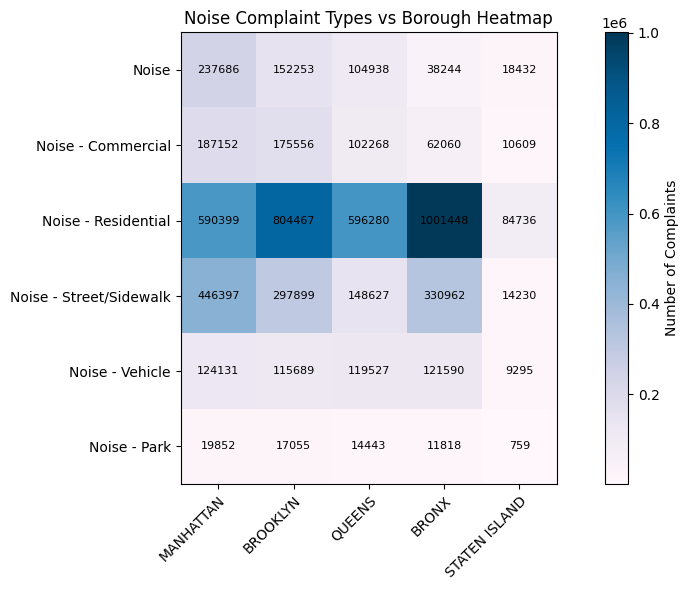

In [10]:
NOISE_TYPES = [
    "Noise", 
    "Noise - Commercial", 
    "Noise - Residential", 
    "Noise - Street/Sidewalk", 
    "Noise - Vehicle", 
    "Noise - Park"
]

# Common boroughs
BOROUGHS = ["MANHATTAN", "BROOKLYN", "QUEENS", "BRONX", "STATEN ISLAND"]

# 1. Filter only Noise complaints
def filter_noise_complaints(data):
    noise_data = []
    for record in data:
        complaint_type = record.get('Complaint Type', '').strip()
        if complaint_type in NOISE_TYPES:
            noise_data.append(record)
    return noise_data

# 2. Count noise complaints per borough
def count_noise_by_borough(noise_data):
    counts = defaultdict(lambda: defaultdict(int))  # nested dictionary
    for record in noise_data:
        complaint_type = record.get('Complaint Type', 'Unknown')
        borough = record.get('Borough', 'Unknown').strip().upper()

        if borough in BOROUGHS:
            counts[complaint_type][borough] += 1
    return counts

# 3. Plot the heatmap
def plot_noise_borough_heatmap(counts):
    complaint_types = NOISE_TYPES
    boroughs = BOROUGHS

    data_matrix = []
    for ctype in complaint_types:
        row = []
        for boro in boroughs:
            row.append(counts[ctype].get(boro, 0))  # get count or 0
        data_matrix.append(row)

    data_matrix = np.array(data_matrix)

    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(data_matrix, cmap='PuBu')

    # Add text annotations inside heatmap
    for i in range(len(complaint_types)):
        for j in range(len(boroughs)):
            text = ax.text(j, i, str(data_matrix[i, j]),
                           ha='center', va='center', color='black', fontsize=8)

    ax.set_xticks(np.arange(len(boroughs)))
    ax.set_yticks(np.arange(len(complaint_types)))
    ax.set_xticklabels(boroughs)
    ax.set_yticklabels(complaint_types)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    ax.set_title("Noise Complaint Types vs Borough Heatmap")
    plt.colorbar(im, ax=ax, orientation='vertical', label='Number of Complaints')
    plt.tight_layout()
    plt.show()

# === Run all ===
noise_data = filter_noise_complaints(cleaned_data)
noise_borough_counts = count_noise_by_borough(noise_data)
plot_noise_borough_heatmap(noise_borough_counts)

Total Food related complaint records: 122638


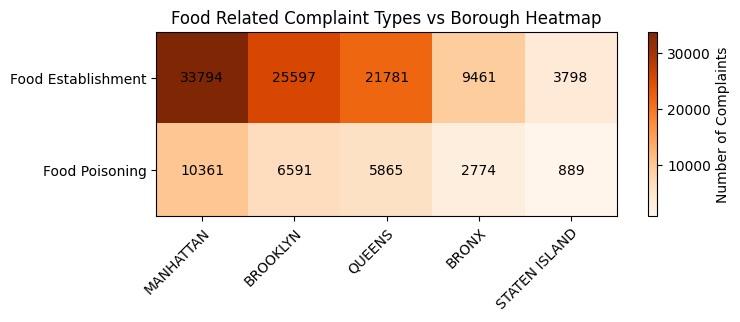

In [11]:
# Food Related complaint types
FOOD_TYPES = [
    "Food Establishment",
    "Food Poisoning"
]

# Common boroughs
BOROUGHS = ["MANHATTAN", "BROOKLYN", "QUEENS", "BRONX", "STATEN ISLAND"]

# 1. Filter only Food complaints
def filter_food_complaints(data):
    food_data = []
    for record in data:
        complaint_type = record.get('Complaint Type', '').strip()
        if complaint_type in FOOD_TYPES:
            food_data.append(record)
    return food_data

# 2. Count food complaints per borough
def count_food_by_borough(food_data):
    counts = defaultdict(lambda: defaultdict(int))  # nested dictionary
    for record in food_data:
        complaint_type = record.get('Complaint Type', 'Unknown')
        borough = record.get('Borough', 'Unknown').strip().upper()

        if borough in BOROUGHS:
            counts[complaint_type][borough] += 1
    return counts

# 3. Plot the heatmap
def plot_food_borough_heatmap(counts):
    complaint_types = FOOD_TYPES
    boroughs = BOROUGHS

    data_matrix = []
    for ctype in complaint_types:
        row = []
        for boro in boroughs:
            row.append(counts[ctype].get(boro, 0))  # get count or 0
        data_matrix.append(row)

    data_matrix = np.array(data_matrix)

    fig, ax = plt.subplots(figsize=(8, 3))
    im = ax.imshow(data_matrix, cmap='Oranges')

    # Add text annotations inside heatmap
    for i in range(len(complaint_types)):
        for j in range(len(boroughs)):
            text = ax.text(j, i, str(data_matrix[i, j]),
                           ha='center', va='center', color='black', fontsize=10)

    ax.set_xticks(np.arange(len(boroughs)))
    ax.set_yticks(np.arange(len(complaint_types)))
    ax.set_xticklabels(boroughs)
    ax.set_yticklabels(complaint_types)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    ax.set_title("Food Related Complaint Types vs Borough Heatmap")
    plt.colorbar(im, ax=ax, orientation='vertical', label='Number of Complaints')
    plt.tight_layout()
    plt.show()

# === Run all ===
food_data = filter_food_complaints(cleaned_data)
print(f"Total Food related complaint records: {len(food_data)}")
food_borough_counts = count_food_by_borough(food_data)
plot_food_borough_heatmap(food_borough_counts)


Total Sanitation related complaint records: 757788


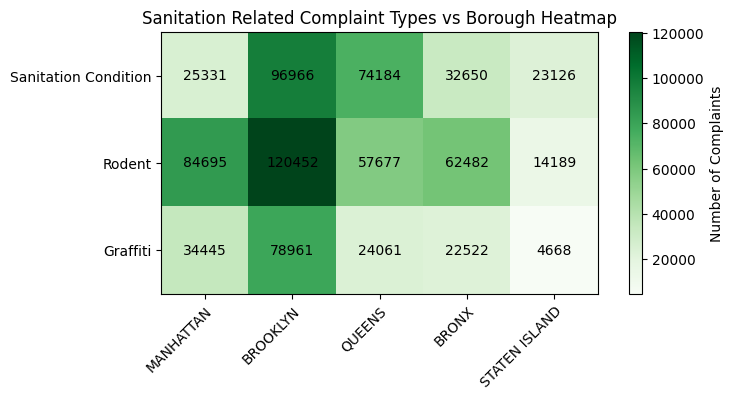

In [12]:
# Sanitation Related complaint types
SANITATION_TYPES = [
    "Sanitation Condition",
    "Rodent",
    "Graffiti"
]

# Common boroughs
BOROUGHS = ["MANHATTAN", "BROOKLYN", "QUEENS", "BRONX", "STATEN ISLAND"]

# 1. Filter sanitation complaints
def filter_sanitation_complaints(data):
    sanitation_data = []
    for record in data:
        complaint_type = record.get('Complaint Type', '').strip()
        if complaint_type in SANITATION_TYPES:
            sanitation_data.append(record)
    return sanitation_data

# 2. Count sanitation complaints per borough
def count_sanitation_by_borough(sanitation_data):
    counts = defaultdict(lambda: defaultdict(int))  # nested dictionary
    for record in sanitation_data:
        complaint_type = record.get('Complaint Type', 'Unknown')
        borough = record.get('Borough', 'Unknown').strip().upper()

        if borough in BOROUGHS:
            counts[complaint_type][borough] += 1
    return counts

# 3. Plot the heatmap
def plot_sanitation_borough_heatmap(counts):
    complaint_types = SANITATION_TYPES
    boroughs = BOROUGHS

    data_matrix = []
    for ctype in complaint_types:
        row = []
        for boro in boroughs:
            row.append(counts[ctype].get(boro, 0))  # get count or 0
        data_matrix.append(row)

    data_matrix = np.array(data_matrix)

    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(data_matrix, cmap='Greens')

    # Add text annotations
    for i in range(len(complaint_types)):
        for j in range(len(boroughs)):
            text = ax.text(j, i, str(data_matrix[i, j]),
                           ha='center', va='center', color='black', fontsize=10)

    ax.set_xticks(np.arange(len(boroughs)))
    ax.set_yticks(np.arange(len(complaint_types)))
    ax.set_xticklabels(boroughs)
    ax.set_yticklabels(complaint_types)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    ax.set_title("Sanitation Related Complaint Types vs Borough Heatmap")
    plt.colorbar(im, ax=ax, orientation='vertical', label='Number of Complaints')
    plt.tight_layout()
    plt.show()

# === Run sanitation heatmap ===
sanitation_data = filter_sanitation_complaints(cleaned_data)
print(f"Total Sanitation related complaint records: {len(sanitation_data)}")
sanitation_borough_counts = count_sanitation_by_borough(sanitation_data)
plot_sanitation_borough_heatmap(sanitation_borough_counts)


Total Parking related complaint records: 4236597


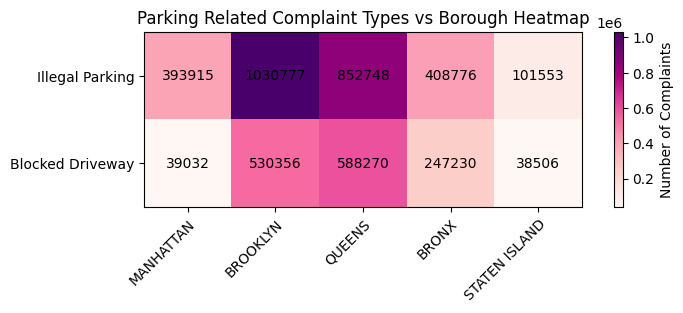

In [13]:
# Parking Related complaint types
PARKING_TYPES = [
    "Illegal Parking",
    "Blocked Driveway"
]

# 1. Filter parking complaints
def filter_parking_complaints(data):
    parking_data = []
    for record in data:
        complaint_type = record.get('Complaint Type', '').strip()
        if complaint_type in PARKING_TYPES:
            parking_data.append(record)
    return parking_data

# 2. Count parking complaints per borough
def count_parking_by_borough(parking_data):
    counts = defaultdict(lambda: defaultdict(int))  # nested dictionary
    for record in parking_data:
        complaint_type = record.get('Complaint Type', 'Unknown')
        borough = record.get('Borough', 'Unknown').strip().upper()

        if borough in BOROUGHS:
            counts[complaint_type][borough] += 1
    return counts

# 3. Plot the heatmap
def plot_parking_borough_heatmap(counts):
    complaint_types = PARKING_TYPES
    boroughs = BOROUGHS

    data_matrix = []
    for ctype in complaint_types:
        row = []
        for boro in boroughs:
            row.append(counts[ctype].get(boro, 0))  # get count or 0
        data_matrix.append(row)

    data_matrix = np.array(data_matrix)

    fig, ax = plt.subplots(figsize=(8, 3))
    im = ax.imshow(data_matrix, cmap='RdPu')

    # Add text annotations
    for i in range(len(complaint_types)):
        for j in range(len(boroughs)):
            text = ax.text(j, i, str(data_matrix[i, j]),
                           ha='center', va='center', color='black', fontsize=10)

    ax.set_xticks(np.arange(len(boroughs)))
    ax.set_yticks(np.arange(len(complaint_types)))
    ax.set_xticklabels(boroughs)
    ax.set_yticklabels(complaint_types)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    ax.set_title("Parking Related Complaint Types vs Borough Heatmap")
    plt.colorbar(im, ax=ax, orientation='vertical', label='Number of Complaints')
    plt.tight_layout()
    plt.show()

# === Run parking heatmap ===
parking_data = filter_parking_complaints(cleaned_data)
print(f"Total Parking related complaint records: {len(parking_data)}")
parking_borough_counts = count_parking_by_borough(parking_data)
plot_parking_borough_heatmap(parking_borough_counts)


Total Other category complaint records: 1224228


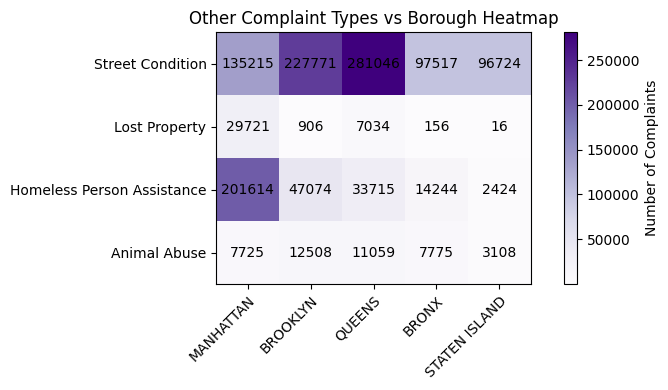

In [14]:
# Other complaint types
OTHER_TYPES = [
    "Street Condition",
    "Lost Property",
    "Homeless Person Assistance",
    "Animal Abuse"
]

# Common boroughs
BOROUGHS = ["MANHATTAN", "BROOKLYN", "QUEENS", "BRONX", "STATEN ISLAND"]

# 1. Filter other complaints
def filter_other_complaints(data):
    other_data = []
    for record in data:
        complaint_type = record.get('Complaint Type', '').strip()
        if complaint_type in OTHER_TYPES:
            other_data.append(record)
    return other_data

# 2. Count other complaints per borough
def count_other_by_borough(other_data):
    counts = defaultdict(lambda: defaultdict(int))  # nested dictionary
    for record in other_data:
        complaint_type = record.get('Complaint Type', 'Unknown')
        borough = record.get('Borough', 'Unknown').strip().upper()

        if borough in BOROUGHS:
            counts[complaint_type][borough] += 1
    return counts

# 3. Plot the heatmap
def plot_other_borough_heatmap(counts):
    complaint_types = OTHER_TYPES
    boroughs = BOROUGHS

    data_matrix = []
    for ctype in complaint_types:
        row = []
        for boro in boroughs:
            row.append(counts[ctype].get(boro, 0))  # get count or 0
        data_matrix.append(row)

    data_matrix = np.array(data_matrix)

    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(data_matrix, cmap='Purples')

    # Add text annotations
    for i in range(len(complaint_types)):
        for j in range(len(boroughs)):
            ax.text(j, i, str(data_matrix[i, j]),
                    ha='center', va='center', color='black', fontsize=10)

    ax.set_xticks(np.arange(len(boroughs)))
    ax.set_yticks(np.arange(len(complaint_types)))
    ax.set_xticklabels(boroughs)
    ax.set_yticklabels(complaint_types)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    ax.set_title("Other Complaint Types vs Borough Heatmap")
    plt.colorbar(im, ax=ax, orientation='vertical', label='Number of Complaints')
    plt.tight_layout()
    plt.show()

# === Run Other Category Heatmap ===
other_data = filter_other_complaints(cleaned_data)
print(f"Total Other category complaint records: {len(other_data)}")
other_borough_counts = count_other_by_borough(other_data)
plot_other_borough_heatmap(other_borough_counts)


In [15]:
# === CONFIGURATION ===
COMPLAINT_TYPES = [
    "Noise", "Noise - Commercial", "Noise - Residential", 
    "Noise - Street/Sidewalk", "Noise - Vehicle", "Noise - Park"
]
MAX_MARKERS_PER_YEAR = 300  # sample size per year to keep it fast
NYC_CENTER = [40.7128, -74.0060]

# === STEP 1: Group records by year (and sample)
def group_records_by_year(data, complaint_types, max_per_year=MAX_MARKERS_PER_YEAR):
    records_by_year = defaultdict(list)

    for record in data:
        try:
            ctype = record.get("Complaint Type", "").strip()
            if ctype not in complaint_types:
                continue

            lat = float(record["Latitude"])
            lon = float(record["Longitude"])
            if lat == 0 or lon == 0:
                continue

            created = record.get("Created Date", "").strip()
            year = datetime.strptime(created, "%Y-%m-%d %H:%M:%S").year
            records_by_year[year].append(record)
        except:
            continue

    # Sample per year
    sampled_by_year = {}
    for year, records in records_by_year.items():
        if len(records) > max_per_year:
            sampled = random.sample(records, max_per_year)
        else:
            sampled = records
        sampled_by_year[year] = sampled
        print(f"✔️ {year}: {len(sampled)} markers")
    
    return sampled_by_year

# === STEP 2: Build Folium Map with popups
def build_popup_cluster_map(records_by_year, output_file="complaints_cluster_popup_map.html"):
    m = folium.Map(location=NYC_CENTER, zoom_start=11, tiles="CartoDB positron")

    for year in sorted(records_by_year):
        fg = folium.FeatureGroup(name=str(year))
        cluster = MarkerCluster().add_to(fg)

        for record in records_by_year[year]:
            try:
                lat = float(record["Latitude"])
                lon = float(record["Longitude"])
                ctype = record.get("Complaint Type", "N/A")
                borough = record.get("Borough", "N/A")
                created = record.get("Created Date", "N/A")

                popup_html = f"""
                <b>Complaint:</b> {ctype}<br>
                <b>Borough:</b> {borough}<br>
                <b>Date:</b> {created}
                """

                folium.Marker(location=[lat, lon], popup=popup_html).add_to(cluster)
            except:
                continue

        fg.add_to(m)

    folium.LayerControl().add_to(m)
    m.save(output_file)
    print(f"✅ Saved map: {output_file}")

# === RUN ===
# Assuming your cleaned dataset is in `cleaned_data`
records_by_year = group_records_by_year(cleaned_data, COMPLAINT_TYPES)
build_popup_cluster_map(records_by_year, "noise_complaints_cluster_popup_map.html")


✔️ 2025: 300 markers
✔️ 2024: 300 markers
✔️ 2023: 300 markers
✔️ 2022: 300 markers
✔️ 2021: 300 markers
✔️ 2020: 300 markers
✔️ 2019: 300 markers
✔️ 2018: 300 markers
✔️ 2017: 300 markers
✔️ 2016: 300 markers
✔️ 2015: 300 markers
✅ Saved map: noise_complaints_cluster_popup_map.html


In [16]:
# === CONFIGURATION ===
COMPLAINT_TYPES = [
 "Food Establishment", "Food Poisoning"
]
MAX_MARKERS_PER_YEAR = 300  # sample size per year to keep it fast
NYC_CENTER = [40.7128, -74.0060]

# === STEP 1: Group records by year (and sample)
def group_records_by_year(data, complaint_types, max_per_year=MAX_MARKERS_PER_YEAR):
    records_by_year = defaultdict(list)

    for record in data:
        try:
            ctype = record.get("Complaint Type", "").strip()
            if ctype not in complaint_types:
                continue

            lat = float(record["Latitude"])
            lon = float(record["Longitude"])
            if lat == 0 or lon == 0:
                continue

            created = record.get("Created Date", "").strip()
            year = datetime.strptime(created, "%Y-%m-%d %H:%M:%S").year
            records_by_year[year].append(record)
        except:
            continue

    # Sample per year
    sampled_by_year = {}
    for year, records in records_by_year.items():
        if len(records) > max_per_year:
            sampled = random.sample(records, max_per_year)
        else:
            sampled = records
        sampled_by_year[year] = sampled
        print(f"✔️ {year}: {len(sampled)} markers")
    
    return sampled_by_year

# === STEP 2: Build Folium Map with popups
def build_popup_cluster_map(records_by_year, output_file="complaints_cluster_popup_map.html"):
    m = folium.Map(location=NYC_CENTER, zoom_start=11, tiles="CartoDB positron")

    for year in sorted(records_by_year):
        fg = folium.FeatureGroup(name=str(year))
        cluster = MarkerCluster().add_to(fg)

        for record in records_by_year[year]:
            try:
                lat = float(record["Latitude"])
                lon = float(record["Longitude"])
                ctype = record.get("Complaint Type", "N/A")
                borough = record.get("Borough", "N/A")
                created = record.get("Created Date", "N/A")

                popup_html = f"""
                <b>Complaint:</b> {ctype}<br>
                <b>Borough:</b> {borough}<br>
                <b>Date:</b> {created}
                """

                folium.Marker(location=[lat, lon], popup=popup_html).add_to(cluster)
            except:
                continue

        fg.add_to(m)

    folium.LayerControl().add_to(m)
    m.save(output_file)
    print(f"✅ Saved map: {output_file}")

# === RUN ===
# Assuming your cleaned dataset is in `cleaned_data`
records_by_year = group_records_by_year(cleaned_data, COMPLAINT_TYPES)
build_popup_cluster_map(records_by_year, "food_complaints_cluster_popup_map.html")


✔️ 2025: 300 markers
✔️ 2024: 300 markers
✔️ 2023: 300 markers
✔️ 2022: 300 markers
✔️ 2021: 300 markers
✔️ 2020: 300 markers
✔️ 2019: 300 markers
✔️ 2018: 300 markers
✔️ 2017: 300 markers
✔️ 2016: 300 markers
✔️ 2015: 300 markers
✅ Saved map: food_complaints_cluster_popup_map.html


In [17]:
# === CONFIGURATION ===
COMPLAINT_TYPES = [
   "Sanitation Condition", "Rodent", "Graffiti"  
]
MAX_MARKERS_PER_YEAR = 300  # sample size per year to keep it fast
NYC_CENTER = [40.7128, -74.0060]

# === STEP 1: Group records by year (and sample)
def group_records_by_year(data, complaint_types, max_per_year=MAX_MARKERS_PER_YEAR):
    records_by_year = defaultdict(list)

    for record in data:
        try:
            ctype = record.get("Complaint Type", "").strip()
            if ctype not in complaint_types:
                continue

            lat = float(record["Latitude"])
            lon = float(record["Longitude"])
            if lat == 0 or lon == 0:
                continue

            created = record.get("Created Date", "").strip()
            year = datetime.strptime(created, "%Y-%m-%d %H:%M:%S").year
            records_by_year[year].append(record)
        except:
            continue

    # Sample per year
    sampled_by_year = {}
    for year, records in records_by_year.items():
        if len(records) > max_per_year:
            sampled = random.sample(records, max_per_year)
        else:
            sampled = records
        sampled_by_year[year] = sampled
        print(f"✔️ {year}: {len(sampled)} markers")
    
    return sampled_by_year

# === STEP 2: Build Folium Map with popups
def build_popup_cluster_map(records_by_year, output_file="complaints_cluster_popup_map.html"):
    m = folium.Map(location=NYC_CENTER, zoom_start=11, tiles="CartoDB positron")

    for year in sorted(records_by_year):
        fg = folium.FeatureGroup(name=str(year))
        cluster = MarkerCluster().add_to(fg)

        for record in records_by_year[year]:
            try:
                lat = float(record["Latitude"])
                lon = float(record["Longitude"])
                ctype = record.get("Complaint Type", "N/A")
                borough = record.get("Borough", "N/A")
                created = record.get("Created Date", "N/A")

                popup_html = f"""
                <b>Complaint:</b> {ctype}<br>
                <b>Borough:</b> {borough}<br>
                <b>Date:</b> {created}
                """

                folium.Marker(location=[lat, lon], popup=popup_html).add_to(cluster)
            except:
                continue

        fg.add_to(m)

    folium.LayerControl().add_to(m)
    m.save(output_file)
    print(f"✅ Saved map: {output_file}")

# === RUN ===
# Assuming your cleaned dataset is in `cleaned_data`
records_by_year = group_records_by_year(cleaned_data, COMPLAINT_TYPES)
build_popup_cluster_map(records_by_year, "sanitation_complaints_cluster_popup_map.html")


✔️ 2025: 300 markers
✔️ 2024: 300 markers
✔️ 2023: 300 markers
✔️ 2022: 300 markers
✔️ 2021: 300 markers
✔️ 2020: 300 markers
✔️ 2019: 300 markers
✔️ 2018: 300 markers
✔️ 2017: 300 markers
✔️ 2016: 300 markers
✔️ 2015: 300 markers
✅ Saved map: sanitation_complaints_cluster_popup_map.html


In [18]:
# === CONFIGURATION ===
COMPLAINT_TYPES = [
   "Illegal Parking", "Blocked Driveway"  
]
MAX_MARKERS_PER_YEAR = 300  # sample size per year to keep it fast
NYC_CENTER = [40.7128, -74.0060]

# === STEP 1: Group records by year (and sample)
def group_records_by_year(data, complaint_types, max_per_year=MAX_MARKERS_PER_YEAR):
    records_by_year = defaultdict(list)

    for record in data:
        try:
            ctype = record.get("Complaint Type", "").strip()
            if ctype not in complaint_types:
                continue

            lat = float(record["Latitude"])
            lon = float(record["Longitude"])
            if lat == 0 or lon == 0:
                continue

            created = record.get("Created Date", "").strip()
            year = datetime.strptime(created, "%Y-%m-%d %H:%M:%S").year
            records_by_year[year].append(record)
        except:
            continue

    # Sample per year
    sampled_by_year = {}
    for year, records in records_by_year.items():
        if len(records) > max_per_year:
            sampled = random.sample(records, max_per_year)
        else:
            sampled = records
        sampled_by_year[year] = sampled
        print(f"✔️ {year}: {len(sampled)} markers")
    
    return sampled_by_year

# === STEP 2: Build Folium Map with popups
def build_popup_cluster_map(records_by_year, output_file="complaints_cluster_popup_map.html"):
    m = folium.Map(location=NYC_CENTER, zoom_start=11, tiles="CartoDB positron")

    for year in sorted(records_by_year):
        fg = folium.FeatureGroup(name=str(year))
        cluster = MarkerCluster().add_to(fg)

        for record in records_by_year[year]:
            try:
                lat = float(record["Latitude"])
                lon = float(record["Longitude"])
                ctype = record.get("Complaint Type", "N/A")
                borough = record.get("Borough", "N/A")
                created = record.get("Created Date", "N/A")

                popup_html = f"""
                <b>Complaint:</b> {ctype}<br>
                <b>Borough:</b> {borough}<br>
                <b>Date:</b> {created}
                """

                folium.Marker(location=[lat, lon], popup=popup_html).add_to(cluster)
            except:
                continue

        fg.add_to(m)

    folium.LayerControl().add_to(m)
    m.save(output_file)
    print(f"✅ Saved map: {output_file}")

# === RUN ===
# Assuming your cleaned dataset is in `cleaned_data`
records_by_year = group_records_by_year(cleaned_data, COMPLAINT_TYPES)
build_popup_cluster_map(records_by_year, "parking_complaints_cluster_popup_map.html")


✔️ 2025: 300 markers
✔️ 2024: 300 markers
✔️ 2023: 300 markers
✔️ 2022: 300 markers
✔️ 2021: 300 markers
✔️ 2020: 300 markers
✔️ 2019: 300 markers
✔️ 2018: 300 markers
✔️ 2017: 300 markers
✔️ 2016: 300 markers
✔️ 2015: 300 markers
✅ Saved map: parking_complaints_cluster_popup_map.html


In [19]:
# === CONFIGURATION ===
COMPLAINT_TYPES = [
   "Street Condition", "Lost Property", "Homeless Person Assistance", "Animal Abuse"  
]
MAX_MARKERS_PER_YEAR = 300  # sample size per year to keep it fast
NYC_CENTER = [40.7128, -74.0060]

# === STEP 1: Group records by year (and sample)
def group_records_by_year(data, complaint_types, max_per_year=MAX_MARKERS_PER_YEAR):
    records_by_year = defaultdict(list)

    for record in data:
        try:
            ctype = record.get("Complaint Type", "").strip()
            if ctype not in complaint_types:
                continue

            lat = float(record["Latitude"])
            lon = float(record["Longitude"])
            if lat == 0 or lon == 0:
                continue

            created = record.get("Created Date", "").strip()
            year = datetime.strptime(created, "%Y-%m-%d %H:%M:%S").year
            records_by_year[year].append(record)
        except:
            continue

    # Sample per year
    sampled_by_year = {}
    for year, records in records_by_year.items():
        if len(records) > max_per_year:
            sampled = random.sample(records, max_per_year)
        else:
            sampled = records
        sampled_by_year[year] = sampled
        print(f"✔️ {year}: {len(sampled)} markers")
    
    return sampled_by_year

# === STEP 2: Build Folium Map with popups
def build_popup_cluster_map(records_by_year, output_file="complaints_cluster_popup_map.html"):
    m = folium.Map(location=NYC_CENTER, zoom_start=11, tiles="CartoDB positron")

    for year in sorted(records_by_year):
        fg = folium.FeatureGroup(name=str(year))
        cluster = MarkerCluster().add_to(fg)

        for record in records_by_year[year]:
            try:
                lat = float(record["Latitude"])
                lon = float(record["Longitude"])
                ctype = record.get("Complaint Type", "N/A")
                borough = record.get("Borough", "N/A")
                created = record.get("Created Date", "N/A")

                popup_html = f"""
                <b>Complaint:</b> {ctype}<br>
                <b>Borough:</b> {borough}<br>
                <b>Date:</b> {created}
                """

                folium.Marker(location=[lat, lon], popup=popup_html).add_to(cluster)
            except:
                continue

        fg.add_to(m)

    folium.LayerControl().add_to(m)
    m.save(output_file)
    print(f"✅ Saved map: {output_file}")

# === RUN ===
# Assuming your cleaned dataset is in `cleaned_data`
records_by_year = group_records_by_year(cleaned_data, COMPLAINT_TYPES)
build_popup_cluster_map(records_by_year, "other_complaints_cluster_popup_map.html")


✔️ 2025: 300 markers
✔️ 2024: 300 markers
✔️ 2023: 300 markers
✔️ 2022: 300 markers
✔️ 2021: 300 markers
✔️ 2020: 300 markers
✔️ 2019: 300 markers
✔️ 2018: 300 markers
✔️ 2017: 300 markers
✔️ 2016: 300 markers
✔️ 2015: 300 markers
✅ Saved map: other_complaints_cluster_popup_map.html


Line Chart: Total Complaints per Year

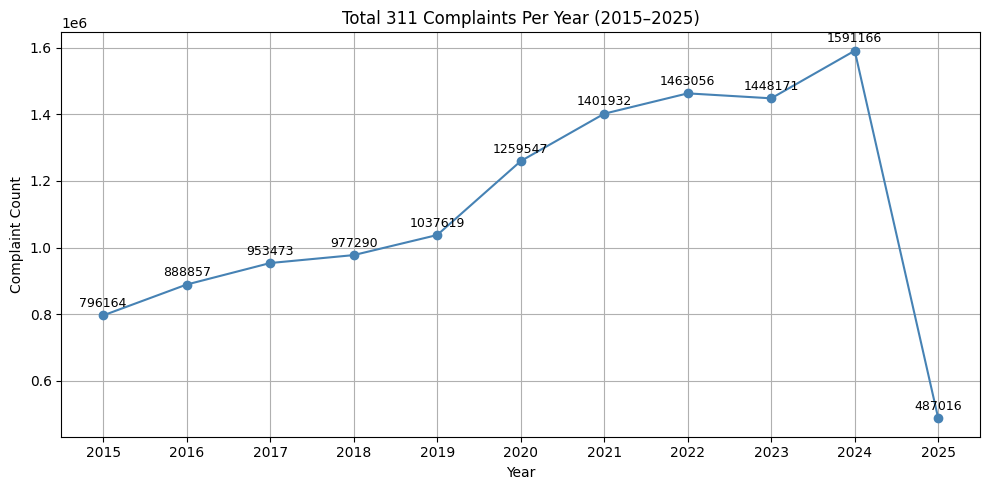

In [20]:
# Step 1: Count complaints per year and fill missing years
def count_by_year(data):
    counts = defaultdict(int)
    for record in data:
        try:
            year = datetime.strptime(record['Created Date'], "%Y-%m-%d %H:%M:%S").year
            counts[year] += 1
        except:
            continue

    # Fill missing years with 0
    full_counts = {}
    for year in range(2015, 2026):
        full_counts[year] = counts.get(year, 0)

    return full_counts

# Step 2: Get the data
year_counts = count_by_year(cleaned_data)
years = list(year_counts.keys())
counts = list(year_counts.values())

# Step 3: Plot with labels
plt.figure(figsize=(10, 5))
plt.plot(years, counts, marker='o', color='steelblue')
plt.title("Total 311 Complaints Per Year (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Complaint Count")
plt.xticks(years)
plt.grid(True)

# Add data labels above each point
for x, y in zip(years, counts):
    plt.text(x, y + max(counts)*0.01, str(y), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Grouped Bar Chart: Category Breakdown by Year

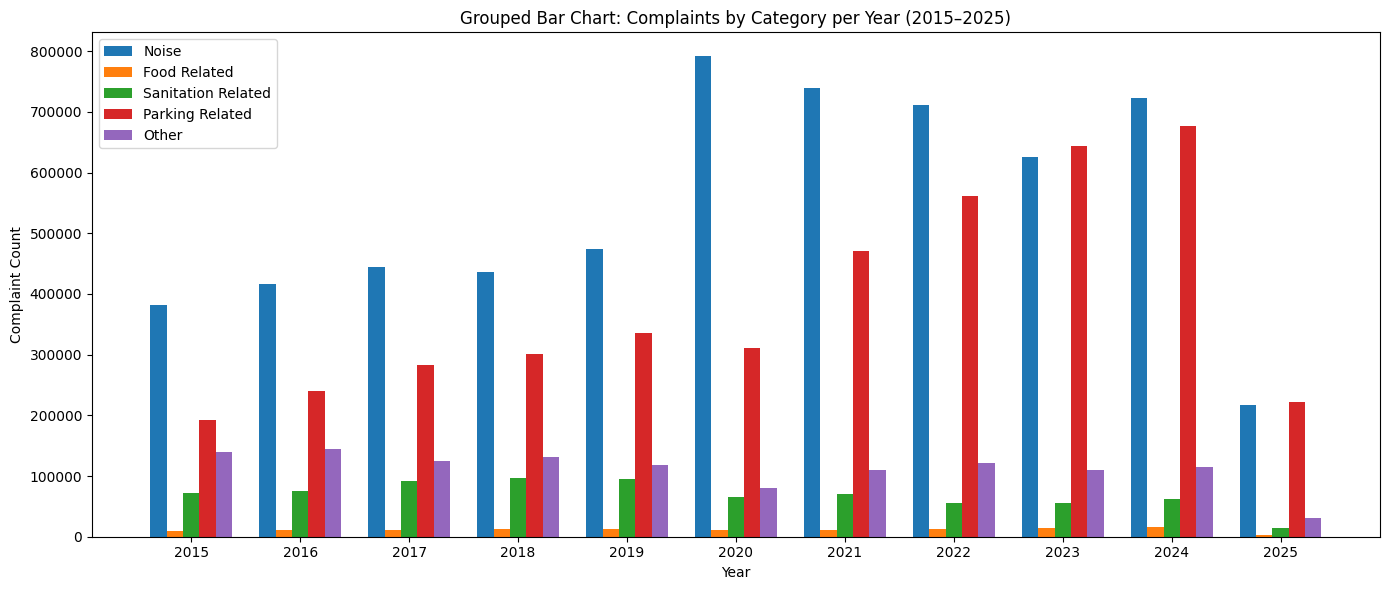

In [21]:
def count_by_year_category(data, category_rules):
    counts = defaultdict(lambda: defaultdict(int))
    for record in data:
        try:
            year = datetime.strptime(record['Created Date'], "%Y-%m-%d %H:%M:%S").year
            ctype = record['Complaint Type'].strip()
            for cat, types in category_rules.items():
                if ctype in types:
                    counts[year][cat] += 1
                    break
        except:
            continue
    return counts

# Fixed year range
years = list(range(2015, 2026))
cat_counts = count_by_year_category(cleaned_data, CATEGORY_RULES)
categories = list(CATEGORY_RULES.keys())

x = np.arange(len(years))  # X locations for each year
bar_width = 0.15

plt.figure(figsize=(14, 6))

# Plot each category as a separate bar group
for i, cat in enumerate(categories):
    values = [cat_counts[year].get(cat, 0) for year in years]
    plt.bar(x + i * bar_width, values, width=bar_width, label=cat)

# Labeling
plt.title("Grouped Bar Chart: Complaints by Category per Year (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Complaint Count")
plt.xticks(x + bar_width * (len(categories)-1)/2, years)
plt.legend()
plt.tight_layout()
plt.show()

Pie Chart of Complaint Types (All Years)

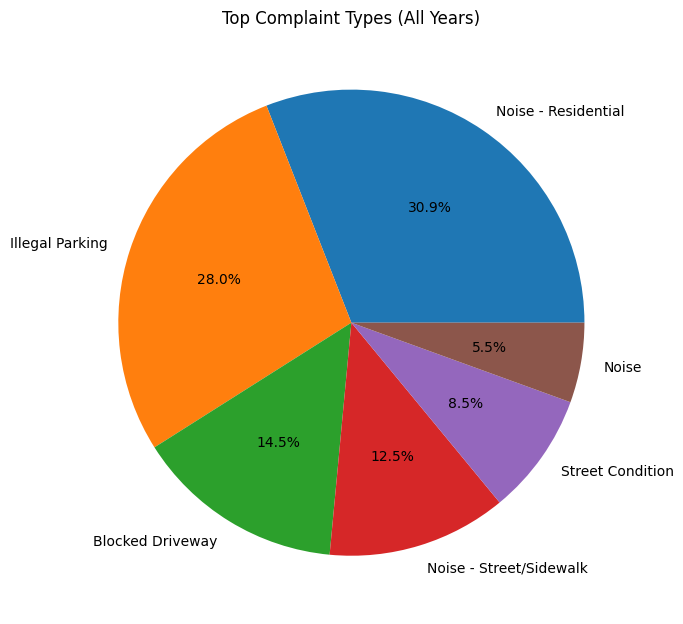

In [22]:
ctype_counts = Counter(record.get("Complaint Type", "Unknown") for record in cleaned_data)
top_items = ctype_counts.most_common(6)
labels, sizes = zip(*top_items)

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Top Complaint Types (All Years)")
plt.tight_layout()
plt.show()


 Borough-wise Complaint Distribution

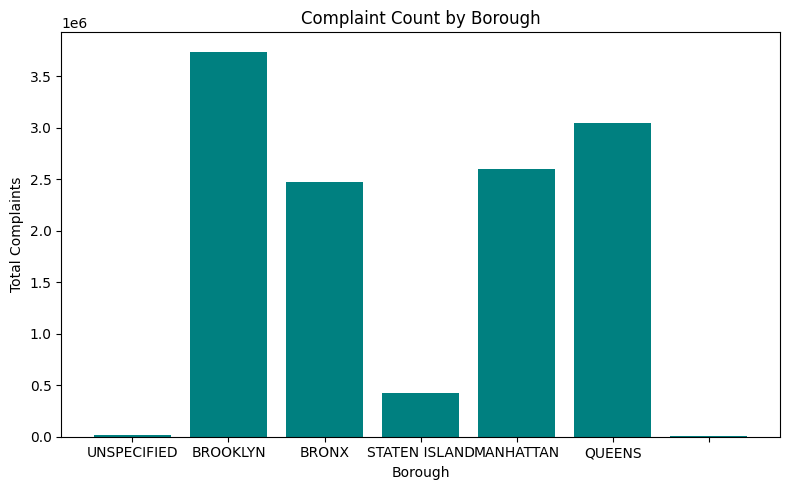

In [23]:
boro_counts = Counter(record.get("Borough", "Unknown").upper() for record in cleaned_data)

plt.figure(figsize=(8, 5))
plt.bar(boro_counts.keys(), boro_counts.values(), color='teal')
plt.title("Complaint Count by Borough")
plt.xlabel("Borough")
plt.ylabel("Total Complaints")
plt.tight_layout()
plt.show()


 Complaint Type Frequency Heatmap (Type vs Year)

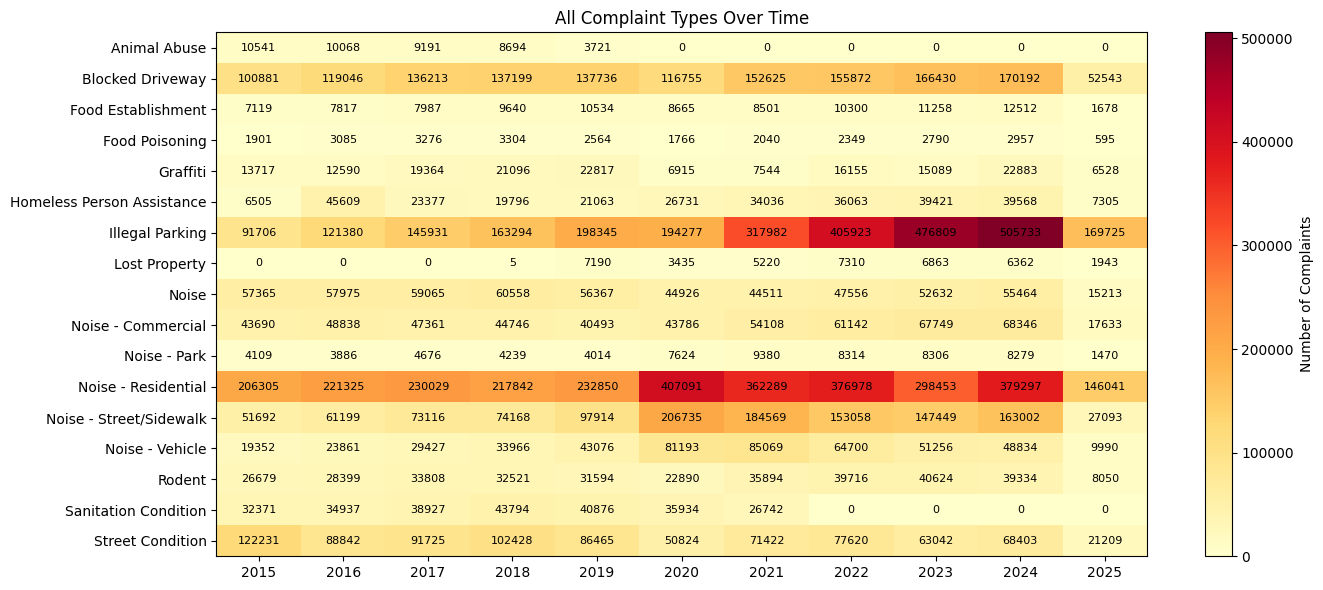

In [24]:
def type_year_matrix_all(data):
    counts = defaultdict(lambda: defaultdict(int))
    all_years = set()
    all_types = set()

    for record in data:
        try:
            year = datetime.strptime(record['Created Date'], "%Y-%m-%d %H:%M:%S").year
            ctype = record['Complaint Type'].strip()
            counts[ctype][year] += 1
            all_years.add(year)
            all_types.add(ctype)
        except:
            continue

    type_labels = sorted(all_types)
    years = sorted(all_years)

    matrix = np.array([[counts[ctype].get(year, 0) for year in years] for ctype in type_labels])
    return matrix, type_labels, years

# === Generate heatmap ===
matrix, types, years = type_year_matrix_all(cleaned_data)

plt.figure(figsize=(14, max(6, len(types) * 0.35)))  # scale figure height to # of types
im = plt.imshow(matrix, cmap='YlOrRd', aspect='auto')

# Axes ticks
plt.xticks(ticks=np.arange(len(years)), labels=years)
plt.yticks(ticks=np.arange(len(types)), labels=types)

# Add text annotations (skip if too crowded)
if len(types) <= 20:
    for i in range(len(types)):
        for j in range(len(years)):
            count = matrix[i, j]
            plt.text(j, i, str(count), ha='center', va='center', color='black', fontsize=8)

# Add color bar and title
plt.colorbar(im, label="Number of Complaints")
plt.title("All Complaint Types Over Time")
plt.tight_layout()
plt.show()


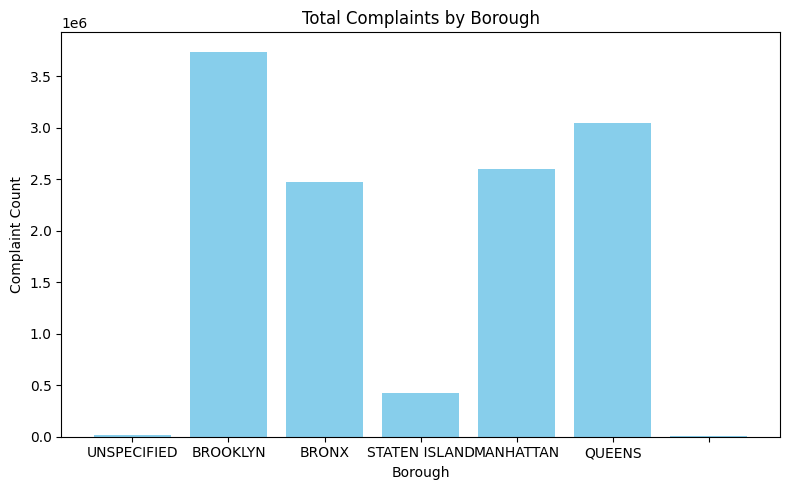

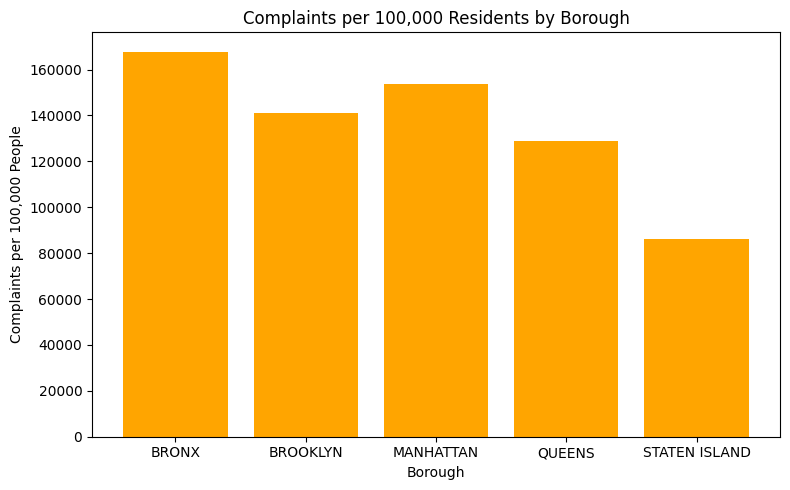

In [25]:
# Count complaints per borough
boro_counts = Counter(record.get("Borough", "UNKNOWN").strip().upper() for record in cleaned_data)

# Population (can update if needed)
borough_population = {
    "BRONX": 1472654,
    "BROOKLYN": 2648452,
    "MANHATTAN": 1694251,
    "QUEENS": 2358582,
    "STATEN ISLAND": 495747
}

# Normalize to complaints per 100,000 people
normalized_per_100k = {}
for boro, pop in borough_population.items():
    total = boro_counts.get(boro, 0)
    normalized_per_100k[boro] = round(total / pop * 100000, 2)

# === Plot 1: Absolute Complaints ===
plt.figure(figsize=(8, 5))
plt.bar(boro_counts.keys(), boro_counts.values(), color='skyblue')
plt.title("Total Complaints by Borough")
plt.xlabel("Borough")
plt.ylabel("Complaint Count")
plt.tight_layout()
plt.show()

# === Plot 2: Normalized per 100,000 ===
plt.figure(figsize=(8, 5))
plt.bar(normalized_per_100k.keys(), normalized_per_100k.values(), color='orange')
plt.title("Complaints per 100,000 Residents by Borough")
plt.xlabel("Borough")
plt.ylabel("Complaints per 100,000 People")
plt.tight_layout()
plt.show()


In [26]:
def analyze_resolution_data(data):
    missing_closed = 0
    invalid_time = 0
    valid = 0

    unresolved_by_type = defaultdict(int)
    total_by_type = defaultdict(int)

    for record in data:
        try:
            created_raw = record.get('Created Date', '').strip()
            closed_raw = record.get('Closed Date', '').strip()
            ctype = record.get('Complaint Type', 'UNKNOWN').strip().title()

            total_by_type[ctype] += 1

            if not created_raw or not closed_raw:
                missing_closed += 1
                unresolved_by_type[ctype] += 1
                continue

            created = datetime.strptime(created_raw, "%Y-%m-%d %H:%M:%S")
            closed = datetime.strptime(closed_raw, "%Y-%m-%d %H:%M:%S")

            diff_hours = (closed - created).total_seconds() / 3600
            if diff_hours <= 0:
                invalid_time += 1
                continue

            valid += 1

        except:
            continue

    return {
        "valid": valid,
        "missing": missing_closed,
        "invalid": invalid_time,
        "unresolved_by_type": unresolved_by_type,
        "total_by_type": total_by_type
    }


In [27]:
def plot_top_unresolved_types(unresolved_by_type, top_n=10):
    sorted_items = sorted(unresolved_by_type.items(), key=lambda x: x[1], reverse=True)[:top_n]
    labels, values = zip(*sorted_items)

    plt.figure(figsize=(12, 5))
    plt.bar(labels, values, color='crimson')
    plt.title("Top Complaint Types Missing Closed Date")
    plt.xlabel("Complaint Type")
    plt.ylabel("Unresolved Complaint Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


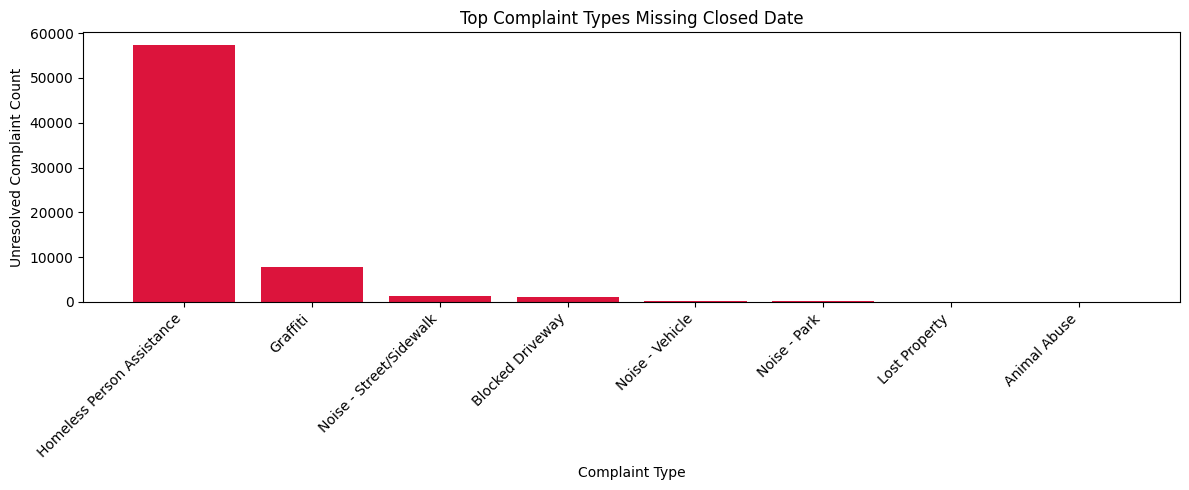

In [28]:
# Step 1: Analyze
results = analyze_resolution_data(cleaned_data)

# Step 2: Visualize
plot_top_unresolved_types(results["unresolved_by_type"])

